# Image Segmentation Project
### A deep learning and computer vision project to segment and locate the image of humans with various backgrounds.
- used U-net architechture with efficientnet-b0 as encoder for CNN to train the model
- used albumentations for randomly augment the image with correspondin the mask
- used a combination of Binary Cross Entropy loss and Dice loss for computing loss
- used OpenCV for reading and pre-processing images
- used cuda runtime for faster training

## Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch 
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=2404acac211a06bf2184d8b58c81c82aa1fc565f0a1072d4fda8da8f289a6e94
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=233fe8220e68ef1f14875c3a37b103363a18975e646af90b01a3a2f9aee0eaa7
  Stored in directory: /root/.cache/pip/w

In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 22.53 MiB/s, done.
Resolving deltas: 100% (3/3), done.


## Some Common Imports

In [33]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [34]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

## Setup Configurations

In [35]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/CONTENT/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [36]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [39]:
row = df.iloc[21]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0

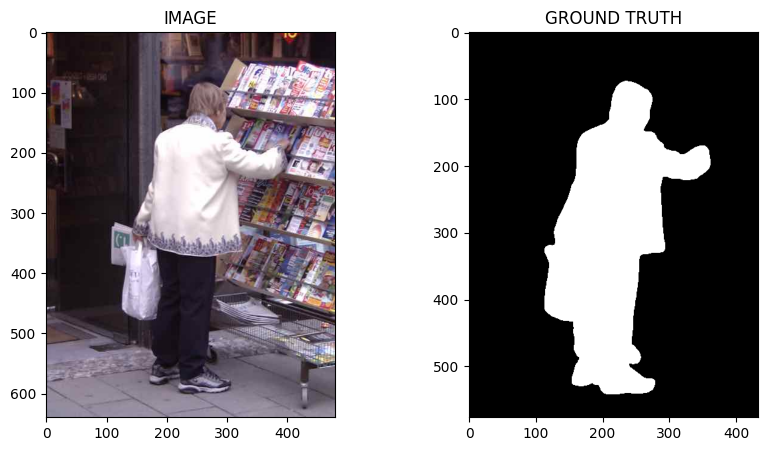

In [40]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [41]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

## Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [42]:
import albumentations as A

In [60]:
def get_train_augs() :
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE, always_apply=True),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ], is_check_shapes=False)

def get_valid_augs() :
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE, always_apply=True)
  ], is_check_shapes=False)


## Create Custom Dataset 

In [44]:
from torch.utils.data import Dataset

In [54]:
class SegmentationDataset(Dataset):
  
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h, w, c)
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask, is_check_shapes=False)
      image = data['image']
      mask = data['mask']

    #(h, w, c) -> (c, h, w)

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image = torch.Tensor(image)/255.0
    mask = torch.Tensor(mask)/255.0

    return image, mask

In [61]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [52]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


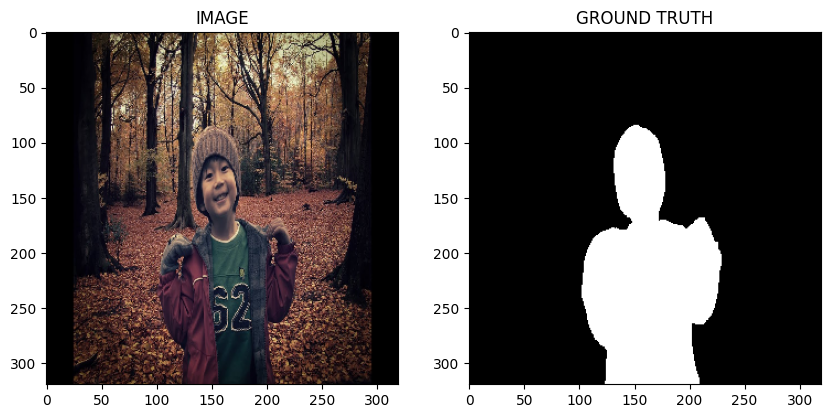

In [62]:
idx = 21

image, mask = trainset[idx]

helper.show_image(image, mask)

## Load dataset into batches

In [63]:
from torch.utils.data import DataLoader 

In [64]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [65]:
print(f"total no. of batches in trainloader: {len(trainloader)}")
print(f"total no. of batches in validloader: {len(validloader)}")

total no. of batches in trainloader: 15
total no. of batches in validloader: 4


In [66]:
for image, mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


## Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [67]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [68]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3, 
        classes = 1,
        activation = None
    )

    def forward(self, images, masks=None):
      logits = self.arc(images)

      if masks != None:
        loss1 = DiceLoss(mode='binary')(logits, masks)
        loss2 = nn.BCEWithLogitsLoss()(logits, masks)
        return logits, loss1+loss2

      return logits

In [69]:
model = SegmentationModel() 
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 75.1MB/s]


## Create Train and Validation Function 

In [ ]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(data_loader)

In [ ]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():  
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)
      
      total_loss += loss.item()

  return total_loss/len(data_loader)

## Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss :
    best_valid_loss = valid_loss 
    torch.save(model.state_dict(), 'best_model.pt')
    print('SAVED-MODEL')

  print(f"Epoch : {i+1} Train_loss : {train_loss} Valid_loss: {valid_loss}")

## Inference

In [ ]:
idx = 20

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))  #(c, h, w) -> (1, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask>0.5)*1.0

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))